<a href="https://colab.research.google.com/github/HarshAg1702/SAR_Colorization/blob/main/sar_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports Libraries
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate
import numpy as np
import cv2
import tensorflow as tf
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


In [ ]:
color_dataset_path = '/kaggle/input/eurosat/dataset/EuroSAT'
gray_scale_dataset_path = '/kaggle/input/eurosat/dataset/EuroSAT_gray_scale'
class_folders = ['River', 'SeaLake', 'Residential', 'Pasture', 'AnnualCrop','Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'PermanentCrop']

In [ ]:
# Function to load and preprocess images from directories
def load_data(color_dataset_path, gray_scale_dataset_path, class_folders, size=(64, 64)):
    X = []  # Grayscale images
    Y = []  # Color images

    for folder in class_folders:
        color_folder = os.path.join(color_dataset_path, folder)
        gray_folder = os.path.join(gray_scale_dataset_path, f"{folder}_gray_scale")

        if not os.path.exists(color_folder) or not os.path.exists(gray_folder):
            print(f"Skipping missing folder: {color_folder} or {gray_folder}")
            continue

        # Lists all files in the color and grayscale folder
        color_files = os.listdir(color_folder)
        gray_files = os.listdir(gray_folder)

        for filename in color_files:
            color_path = os.path.join(color_folder, filename)
            gray_path = os.path.join(gray_folder, filename)

            if not os.path.isfile(color_path) or not os.path.isfile(gray_path):
                print(f"Skipping missing files: {color_path} or {gray_path}")
                continue

            color_img = cv2.imread(color_path)
            gray_img = cv2.imread(gray_path, cv2.IMREAD_GRAYSCALE)

            if color_img is None or gray_img is None:
                print(f"Error loading images: {color_path} or {gray_path}")
                continue

            # Resizes images to the desired size
            color_img = cv2.resize(color_img, size)
            gray_img = cv2.resize(gray_img, size)

            # Expands dimensions of grayscale image to (height, width, 1)
            gray_img = np.expand_dims(gray_img, axis=-1)

            # Normalizes pixel values to [0, 1]
            X.append(gray_img / 255.0)
            Y.append(color_img / 255.0)

    return np.array(X), np.array(Y)

In [ ]:
# U-Net architecture for colorization
def build_colorization_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c7)  # 3 channels for RGB color

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = build_colorization_model((64, 64, 1))  # Input is grayscale
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 256) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,781,891 (29.69 MB)

 Trainable params: 7,781,891 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X, Y = load_data(color_dataset_path, gray_scale_dataset_path, class_folders, size=(64, 64))

# Splits the data into training and validation sets
X_train, X_val = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
Y_train, Y_val = Y[:int(0.8*len(Y))], Y[int(0.8*len(Y)):]

In [ ]:
print(f"Shape of X (grayscale images): {X.shape}")
print(f"Shape of Y (color images): {Y.shape}")


Shape of X (grayscale images): (27000, 64, 64, 1)
Shape of Y (color images): (27000, 64, 64, 3)


In [ ]:
X[0].shape

(64, 64, 1)

In [ ]:
model.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
)


In [ ]:
# Training
try:
    history = model.fit(X_train, Y_train, batch_size=16, epochs=50, validation_data=(X_val, Y_val))

    # Model weights
    weights_path = 'colorization_model_weights.weights.h5'
    model.save_weights(weights_path)
    print(f"Model weights saved successfully to {weights_path}.")

except Exception as e:
    print(f"Error during training: {e}")

Epoch 1/50


I0000 00:00:1743513885.992826     104 service.cc:145] XLA service 0x78623c017810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743513885.992889     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1743513885.992893     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   3/1350 ━━━━━━━━━━━━━━━━━━━━ 1:21 60ms/step - loss: 0.0358

I0000 00:00:1743513900.548991     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 94s 56ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 71s 53ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - loss: 9.9251e-04 - val_loss: 0.0016
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - loss: 9.3898e-04 - val_loss: 0.0012
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - loss: 8.9904e-04 - val_loss: 0.0012
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - loss: 8.8167e-04 - val_loss: 0.0011
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 68s 50ms/step - loss: 8.5487e-04 - val_loss: 0.0013
Epoch 9/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 8.3828e-04 - val_loss: 0.0012
Epoch 10/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 8.1734e-04 - val_loss: 0.0011
Epoch 11/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - loss: 8.1213e-04 - val_

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_model(model, X_val, Y_val, display_interval=10):
    total_ssim, total_psnr = 0, 0
    num_samples = len(X_val)

    print(f"Total images to process: {num_samples}")

    for i in range(num_samples):
        grayscale_image = np.expand_dims(X_val[i], axis=0)  # Add batch dim
        true_color_image = Y_val[i]

        # Get model prediction
        predicted_image = model.predict(grayscale_image, verbose=0)[0]
        min_dim = min(predicted_image.shape[:2])
        win_size = min(7, min_dim)

        #SSIM and PSNR
        ssim_value = ssim(true_color_image, predicted_image, data_range=1, win_size=win_size, channel_axis=-1)
        psnr_value = psnr(true_color_image, predicted_image, data_range=1)

        total_ssim += ssim_value
        total_psnr += psnr_value

        # Progress at intervals
        if (i + 1) % display_interval == 0 or (i + 1) == num_samples:
            print(f"Processed {i + 1}/{num_samples} images...")

    avg_ssim = total_ssim / num_samples
    avg_psnr = total_psnr / num_samples

    print(f"\nEvaluation Complete ✅")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f} dB")

evaluate_model(model, X_val, Y_val, display_interval=200)


Total images to process: 5400
Processed 200/5400 images...
Processed 400/5400 images...
Processed 600/5400 images...
Processed 800/5400 images...
Processed 1000/5400 images...
Processed 1200/5400 images...
Processed 1400/5400 images...
Processed 1600/5400 images...
Processed 1800/5400 images...
Processed 2000/5400 images...
Processed 2200/5400 images...
Processed 2400/5400 images...
Processed 2600/5400 images...
Processed 2800/5400 images...
Processed 3000/5400 images...
Processed 3200/5400 images...
Processed 3400/5400 images...
Processed 3600/5400 images...
Processed 3800/5400 images...
Processed 4000/5400 images...
Processed 4200/5400 images...
Processed 4400/5400 images...
Processed 4600/5400 images...
Processed 4800/5400 images...
Processed 5000/5400 images...
Processed 5200/5400 images...
Processed 5400/5400 images...

Evaluation Complete ✅
Average SSIM: 0.9760
Average PSNR: 31.4834 dB


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf

def pixel_by_pixel_similarity(predicted_image, true_image):
    predicted_image = np.round(predicted_image).astype(int)
    true_image = np.round(true_image).astype(int)

    # Reshape to flatten the images
    predicted_image_flatten = predicted_image.flatten()
    true_image_flatten = true_image.flatten()

    # Compute the pixel-by-pixel accuracy
    accuracy = accuracy_score(true_image_flatten, predicted_image_flatten)

    return accuracy * 100

def evaluate_pixel_similarity(model, X_val, Y_val, display_interval=100):
    total_similarity = 0
    total_images = len(X_val)

    print(f"Total images to process: {total_images}")

    # Loop through all validation images
    for i in range(total_images):
        grayscale_image = X_val[i:i+1]
        true_color_image = Y_val[i]
        predicted_image = model.predict(grayscale_image, verbose=0)[0]

        # Evaluate pixel-by-pixel similarity
        similarity = pixel_by_pixel_similarity(predicted_image, true_color_image)
        total_similarity += similarity

        # Progress at intervals
        if (i + 1) % display_interval == 0 or (i + 1) == total_images:
            print(f"Processed {i + 1}/{total_images} images")

    # Calculate average similarity across all images
    avg_similarity = total_similarity / total_images
    print(f"Average Pixel-by-Pixel Similarity: {avg_similarity:.2f}% ✅")

evaluate_pixel_similarity(model, X_val, Y_val, display_interval=400)


Total images to process: 5400
Processed 400/5400 images
Processed 800/5400 images
Processed 1200/5400 images
Processed 1600/5400 images
Processed 2000/5400 images
Processed 2400/5400 images
Processed 2800/5400 images
Processed 3200/5400 images
Processed 3600/5400 images
Processed 4000/5400 images
Processed 4400/5400 images
Processed 4800/5400 images
Processed 5200/5400 images
Processed 5400/5400 images
Average Pixel-by-Pixel Similarity: 95.38% ✅


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/kaggle/input/sar/keras/default/1/colorization_model.keras")
print("Model loaded successfully! ✅")


Model loaded successfully! ✅


I0000 00:00:1743581267.305960     108 service.cc:145] XLA service 0x7df9d0003f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743581267.306014     108 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1743581267.306018     108 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1743581272.493195     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


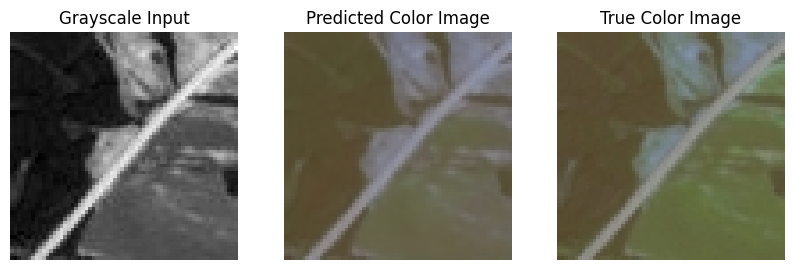

In [ ]:
# Test function to visualize predictions
def test_model(model, X_val, Y_val, index=0):
    grayscale_img = X_val[index]
    true_color_img = Y_val[index]
    grayscale_img_batch = np.expand_dims(grayscale_img, axis=0)

    # Predict the colorized image
    predicted_color_img = model.predict(grayscale_img_batch)[0]  # Remove batch dimension after prediction

    # Rescale from [0, 1] to [0, 255] for display purposes
    predicted_color_img = (predicted_color_img * 255).astype(np.uint8)
    true_color_img = (true_color_img * 255).astype(np.uint8)
    grayscale_img = (grayscale_img.squeeze() * 255).astype(np.uint8)

    # Display images for comparison
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Image")
    plt.imshow(predicted_color_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("True Color Image")
    plt.imshow(true_color_img)
    plt.axis('off')

    plt.show()


test_model(model, X_val, Y_val, index=1)

In [ ]:
# Save the trained model
model.save("colorization_model.keras")
print("Model saved successfully...")


Model saved successfully...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


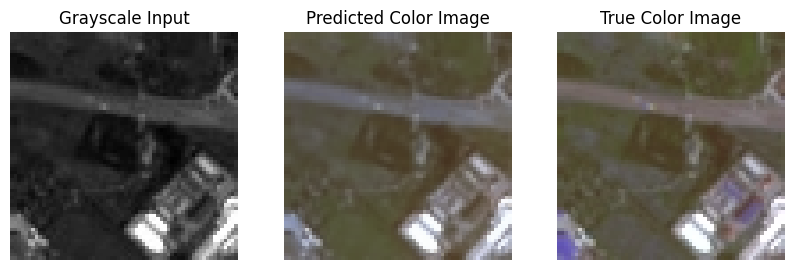

In [ ]:
# Test function to visualize predictions
def test_model(model, X_val, Y_val, index=0):
    grayscale_img = X_val[index]
    true_color_img = Y_val[index]
    grayscale_img_batch = np.expand_dims(grayscale_img, axis=0)

    # Predict the colorized image
    predicted_color_img = model.predict(grayscale_img_batch)[0]  # Remove batch dimension after prediction

    # Rescale from [0, 1] to [0, 255] for display purposes
    predicted_color_img = (predicted_color_img * 255).astype(np.uint8)
    true_color_img = (true_color_img * 255).astype(np.uint8)
    grayscale_img = (grayscale_img.squeeze() * 255).astype(np.uint8)

    # Display images for comparison
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Image")
    plt.imshow(predicted_color_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("True Color Image")
    plt.imshow(true_color_img)
    plt.axis('off')

    plt.show()


test_model(model, X_val, Y_val, index=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


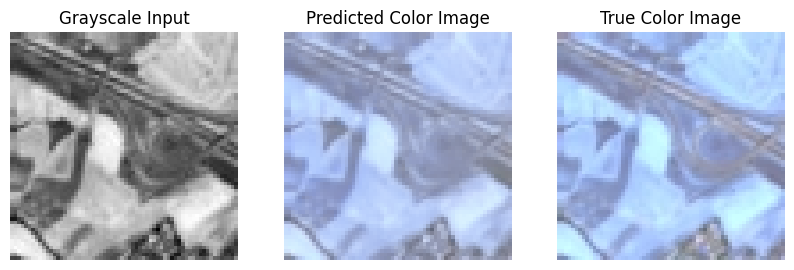

In [ ]:
# Test function to visualize predictions
def test_model(model, X_val, Y_val, index=0):
    grayscale_img = X_val[index]
    true_color_img = Y_val[index]
    grayscale_img_batch = np.expand_dims(grayscale_img, axis=0)

    # Predict the colorized image
    predicted_color_img = model.predict(grayscale_img_batch)[0]  # Remove batch dimension after prediction

    # Rescale from [0, 1] to [0, 255] for display purposes
    predicted_color_img = (predicted_color_img * 255).astype(np.uint8)
    true_color_img = (true_color_img * 255).astype(np.uint8)
    grayscale_img = (grayscale_img.squeeze() * 255).astype(np.uint8)

    # Display images for comparison
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Image")
    plt.imshow(predicted_color_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("True Color Image")
    plt.imshow(true_color_img)
    plt.axis('off')

    plt.show()


test_model(model, X_val, Y_val, index=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


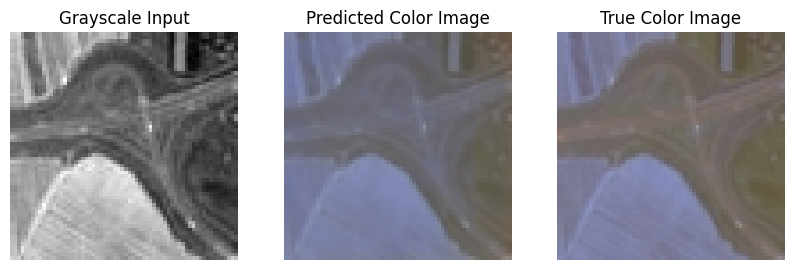

In [ ]:
# Test function to visualize predictions
def test_model(model, X_val, Y_val, index=0):
    grayscale_img = X_val[index]
    true_color_img = Y_val[index]
    grayscale_img_batch = np.expand_dims(grayscale_img, axis=0)

    # Predict the colorized image
    predicted_color_img = model.predict(grayscale_img_batch)[0]  # Remove batch dimension after prediction

    # Rescale from [0, 1] to [0, 255] for display purposes
    predicted_color_img = (predicted_color_img * 255).astype(np.uint8)
    true_color_img = (true_color_img * 255).astype(np.uint8)
    grayscale_img = (grayscale_img.squeeze() * 255).astype(np.uint8)

    # Display images for comparison
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Image")
    plt.imshow(predicted_color_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("True Color Image")
    plt.imshow(true_color_img)
    plt.axis('off')

    plt.show()


test_model(model, X_val, Y_val, index=4)